In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

In [32]:
# Provide the file paths for the datasets
customers_path = '/content/drive/MyDrive/Datasets/Customers.csv'
products_path = '/content/drive/MyDrive/Datasets/Products.csv'
transactions_path = '/content/drive/MyDrive/Datasets/Transactions.csv'

# Load datasets
customers = pd.read_csv(customers_path)
products = pd.read_csv(products_path)
transactions = pd.read_csv(transactions_path)

# Display first few rows of each dataset
print("Customers Data:")
print(customers.head())

print("\nProducts Data:")
print(products.head())

print("\nTransactions Data:")
print(transactions.head())

Customers Data:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Products Data:
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31

Transactions Data:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127 

In [17]:
# Convert TransactionDate to datetime
transactions["TransactionDate"] = pd.to_datetime(transactions["TransactionDate"])
transactions["Year"] = transactions["TransactionDate"].dt.year

In [18]:
# Check data info
print(customers.info())
print(products.info())
print(transactions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           -------

In [19]:
# Merge datasets
merged_data = transactions.merge(products, on="ProductID").merge(customers, on="CustomerID")

In [33]:
# Feature Extraction
customer_features = merged_data.groupby("CustomerID").agg(
    total_spent=("TotalValue", "sum"),
    num_transactions=("TransactionID", "count"),
    avg_transaction_value=("TotalValue", "mean"),
    preferred_category=("Category", lambda x: x.mode()[0] if not x.mode().empty else None),
    region=("Region", "first")
).reset_index()

In [34]:
# Encode categorical features
customer_features_encoded = pd.get_dummies(customer_features, columns=["preferred_category", "region"], drop_first=True)

In [35]:
# Standardize numerical features
scaler = StandardScaler()
numerical_features = ["total_spent", "num_transactions", "avg_transaction_value"]
customer_features_encoded[numerical_features] = scaler.fit_transform(customer_features_encoded[numerical_features])

In [51]:
# Clustering
# Select the optimal number of clusters
max_clusters = 10
db_scores = []
silhouette_scores = []
cluster_range = range(2, max_clusters + 1)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(customer_features_encoded.drop("CustomerID", axis=1))
    db_index = davies_bouldin_score(customer_features_encoded.drop("CustomerID", axis=1), cluster_labels)
    silhouette_avg = silhouette_score(customer_features_encoded.drop("CustomerID", axis=1), cluster_labels)
    db_scores.append(db_index)
    silhouette_scores.append(silhouette_avg)

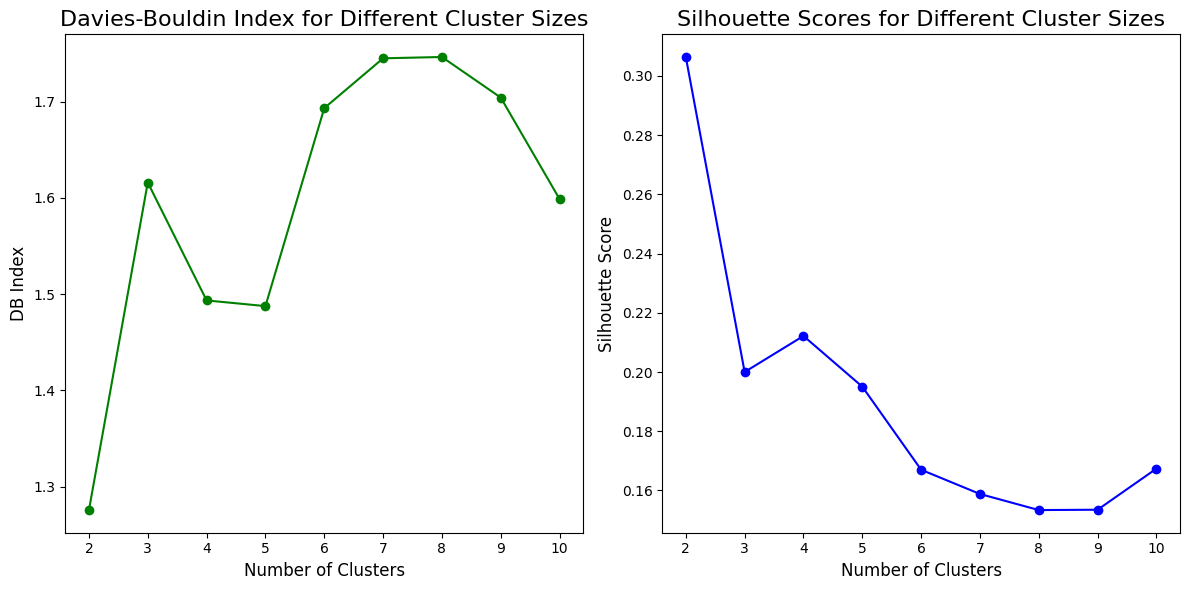

In [52]:
# Plot DB Index and Silhouette Scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, db_scores, marker="o", color="green")
plt.title("Davies-Bouldin Index for Different Cluster Sizes", fontsize=16)
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("DB Index", fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker="o", color="blue")
plt.title("Silhouette Scores for Different Cluster Sizes", fontsize=16)
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)

plt.tight_layout()
plt.show()

In [53]:
# Select the number of clusters with the lowest DB Index
optimal_clusters = cluster_range[db_scores.index(min(db_scores))]
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_features_encoded["Cluster"] = kmeans.fit_predict(customer_features_encoded.drop("CustomerID", axis=1))

In [54]:
# Calculate Final Metrics
final_db_index = davies_bouldin_score(customer_features_encoded.drop(["CustomerID", "Cluster"], axis=1), customer_features_encoded["Cluster"])
final_silhouette_score = silhouette_score(customer_features_encoded.drop(["CustomerID", "Cluster"], axis=1), customer_features_encoded["Cluster"])
print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"Final Davies-Bouldin Index: {final_db_index:.2f}")
print(f"Final Silhouette Score: {final_silhouette_score:.2f}")

Optimal Number of Clusters: 2
Final Davies-Bouldin Index: 1.39
Final Silhouette Score: 0.26


In [55]:
# Visualize Clusters (using the first two principal components)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
customer_features_pca = pca.fit_transform(customer_features_encoded.drop(["CustomerID", "Cluster"], axis=1))

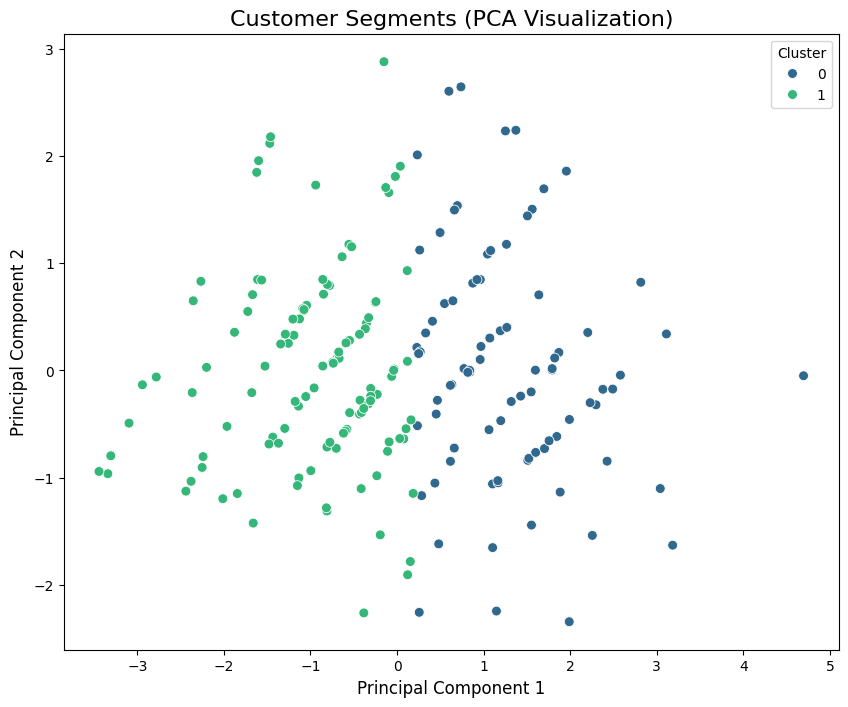

In [56]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=customer_features_pca[:, 0], y=customer_features_pca[:, 1],
    hue=customer_features_encoded["Cluster"], palette="viridis", s=50
)
plt.title("Customer Segments (PCA Visualization)", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.legend(title="Cluster")
plt.show()

In [57]:
# Save clustering results
customer_segments = customer_features_encoded[["CustomerID", "Cluster"]]
customer_segments.to_csv("Customer_Segments.csv", index=False)

In [58]:
# Summary Report
print("Clustering Summary:")
print(f"Number of Clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index: {final_db_index:.2f}")
print(f"Silhouette Score: {final_silhouette_score:.2f}")

Clustering Summary:
Number of Clusters: 2
Davies-Bouldin Index: 1.39
Silhouette Score: 0.26
